<a href="https://colab.research.google.com/github/Meetkuber/stock-market-pred-moddel/blob/main/LSTM_Model_For_Stock_Market_Prediction_DLNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance --quiet
!pip install tensorflow --quiet
!pip install scikit-learn --quiet
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=d94f684755af89f0948b141635bfc0cc0421fefb50db035fb31b4accc2069981
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, Bidirectional, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

/tmp/ipython-input-3327830034.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start='2018-01-01', end='2023-12-31')['Close'].dropna()
[*********************100%***********************]  4 of 4 completed


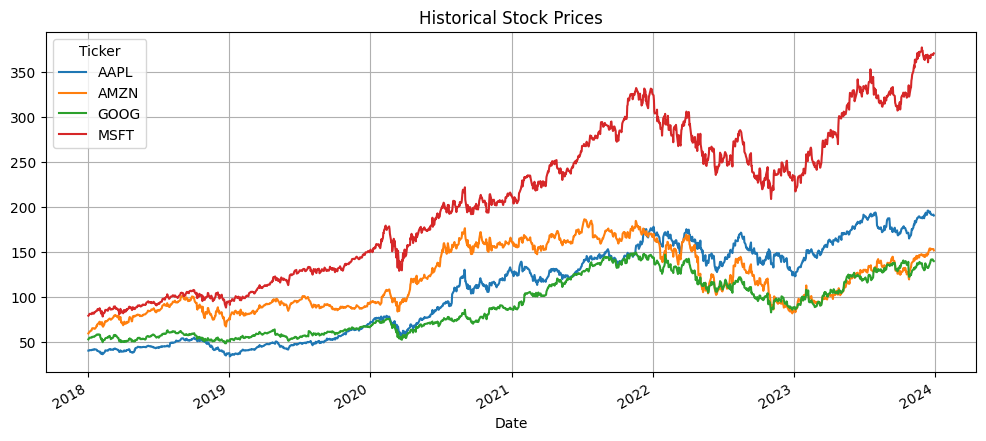

In [ ]:
tickers = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
data = yf.download(tickers, start='2018-01-01', end='2023-12-31')['Close'].dropna()
data.plot(figsize=(12, 5), title='Historical Stock Prices')
plt.grid(True)
plt.show()

In [ ]:
window_size = 100
steps_ahead = 10
X_all_dict, y_all_dict, scalers, df_dict = {}, {}, {}, {}

# Ensure data is a pandas DataFrame, as expected for column indexing by ticker.
# This re-initializes 'data' in case its type was unexpectedly changed.
data = yf.download(tickers, start='2018-01-01', end='2023-12-31')['Close'].dropna()

for ticker in tickers:
    series = data[ticker].values.reshape(-1, 1)
    scaler = MinMaxScaler()
    series_scaled = scaler.fit_transform(series).flatten()

    X_list, y_list = [], []
    for i in range(len(series_scaled) - window_size - steps_ahead + 1):
        X_list.append(series_scaled[i:i+window_size])
        y_list.append(series_scaled[i+window_size:i+window_size+steps_ahead])

    X = np.expand_dims(np.array(X_list), axis=-1)
    y = np.array(y_list)

    X_all_dict[ticker] = X
    y_all_dict[ticker] = y
    scalers[ticker] = scaler
    df_dict[ticker] = series

/tmp/ipython-input-3731376712.py:7: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  4 of 4 completed


In [ ]:
def profit_directional_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    true_diff = y_true[:, 1:] - y_true[:, :-1]
    pred_diff = y_pred[:, 1:] - y_pred[:, :-1]
    mismatch = tf.cast(tf.not_equal(tf.sign(true_diff), tf.sign(pred_diff)), tf.float32)
    direction_loss = tf.reduce_mean(mismatch)
    return mse + 0.5 * direction_loss

In [ ]:
class Attention(Layer):
    def __init__(self):
        super(Attention, self).__init__()
        self.W = Dense(1, activation='tanh')

    def call(self, inputs):
        scores = self.W(inputs)
        weights = tf.nn.softmax(scores, axis=1)
        context = tf.reduce_sum(inputs * weights, axis=1)
        return context

In [ ]:
def build_model():
    input_layer = Input(shape=(window_size, 1))

    # Feature extraction via CNN
    x = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(input_layer)
    x = MaxPooling1D(pool_size=2)(x)

    # Bidirectional LSTM Layers
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(32, return_sequences=True))(x)

    # Attention mechanism
    x = Attention()(x)
    x = Dropout(0.3)(x)

    # Output Layer
    output = Dense(steps_ahead)(x)

    # Model compilation
    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-3), loss=profit_directional_loss)

    return model

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Conv1D, MaxPooling1D

models = {}
histories = {}

# Callback to reduce LR on plateau
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
]

for ticker in tickers:
    X_all = X_all_dict[ticker]
    y_all = y_all_dict[ticker]

    # Build and compile the refined model
    model = build_model()
    print(f"\nTraining model for {ticker}")

    # Train model with validation split
    history = model.fit(
        X_all, y_all,
        epochs=300,
        batch_size=256,
        validation_split=0.2,
        verbose=1,
        callbacks=callbacks
    )

    # Save model and training history
    models[ticker] = model
    histories[ticker] = history



Training model for AAPL
Epoch 1/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 686ms/step - loss: 0.4581 - val_loss: 0.5757 - learning_rate: 0.0010
Epoch 2/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 504ms/step - loss: 0.3373 - val_loss: 0.3084 - learning_rate: 0.0010
Epoch 3/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 513ms/step - loss: 0.2954 - val_loss: 0.2844 - learning_rate: 0.0010
Epoch 4/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 390ms/step - loss: 0.2777 - val_loss: 0.3197 - learning_rate: 0.0010
Epoch 5/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 386ms/step - loss: 0.2742 - val_loss: 0.2783 - learning_rate: 0.0010
Epoch 6/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 395ms/step - loss: 0.2710 - val_loss: 0.2584 - learning_rate: 0.0010
Epoch 7/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 387ms/step - loss: 0.2697 - val_loss: 0.2684 - learning_rate: 0.0010
Epoch 8/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 475ms/step - loss: 0.2672 - val_loss: 0.2653 - learning_rate: 0.0010
Epoch 9/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 486ms/step - loss: 0.2689 - val_loss: 0.2624 - learning_rate: 

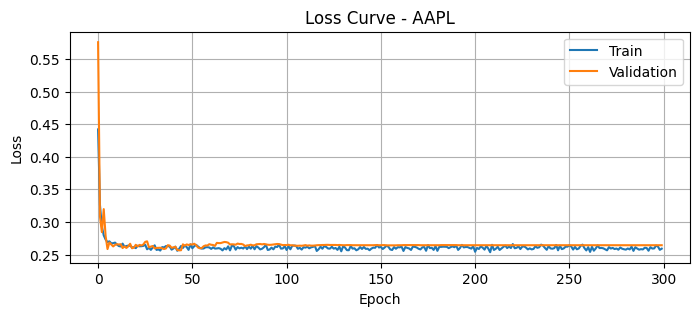

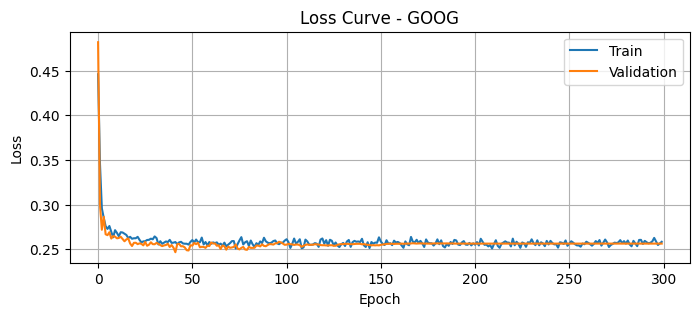

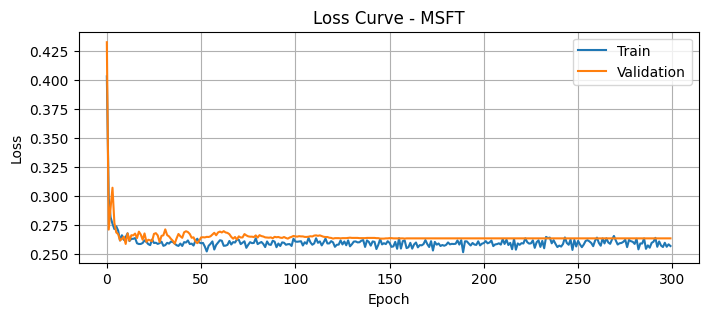

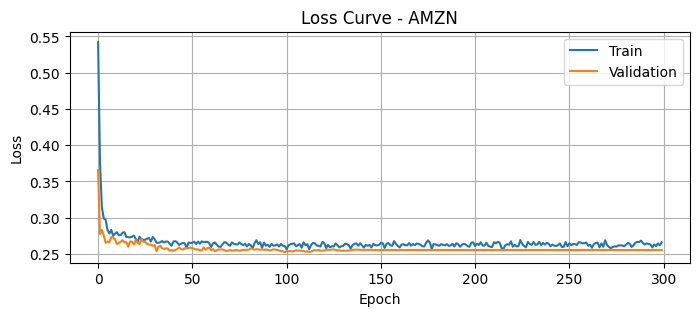

In [ ]:
for ticker in tickers:
    if ticker not in histories:
        print(f"Skipping {ticker}, no training history available.")
        continue

    hist = histories[ticker]
    plt.figure(figsize=(8, 3))
    plt.plot(hist.history['loss'], label="Train")
    plt.plot(hist.history['val_loss'], label="Validation")
    plt.title(f"Loss Curve - {ticker}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step


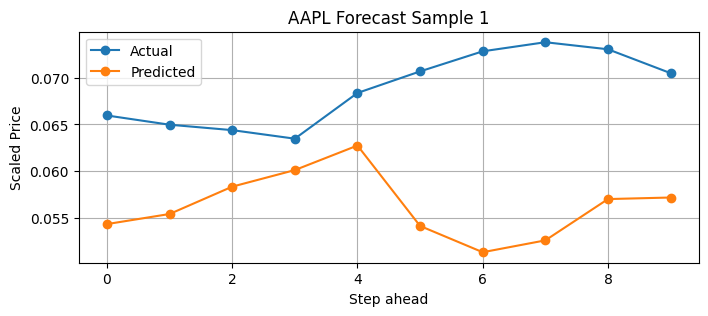

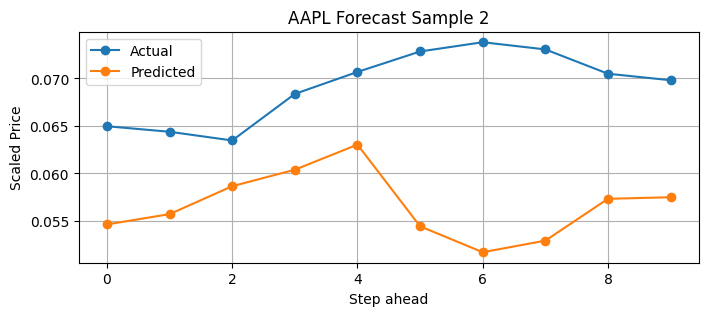

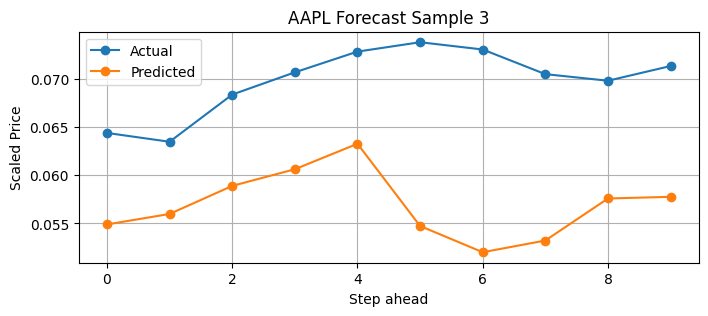

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step


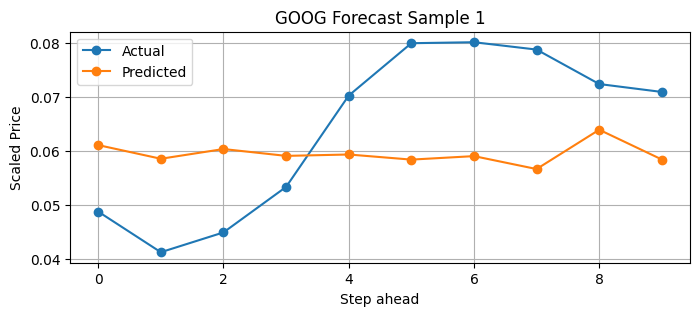

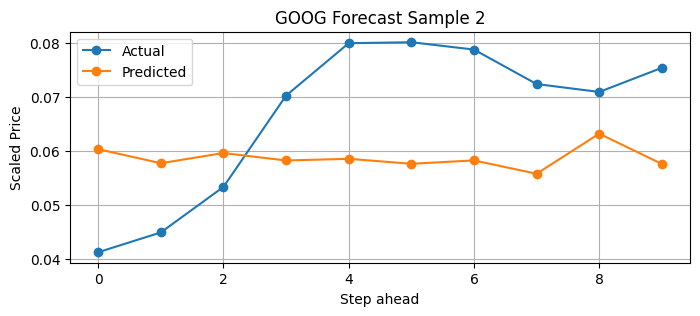

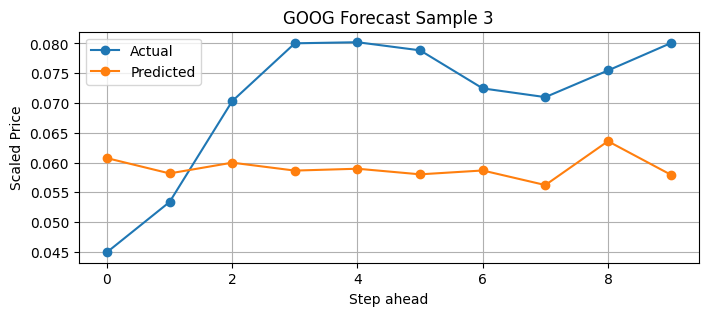

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step


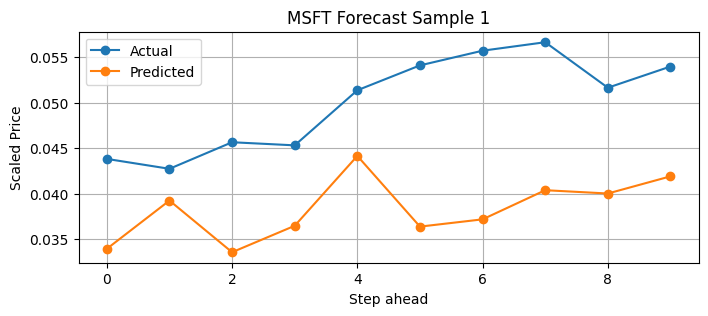

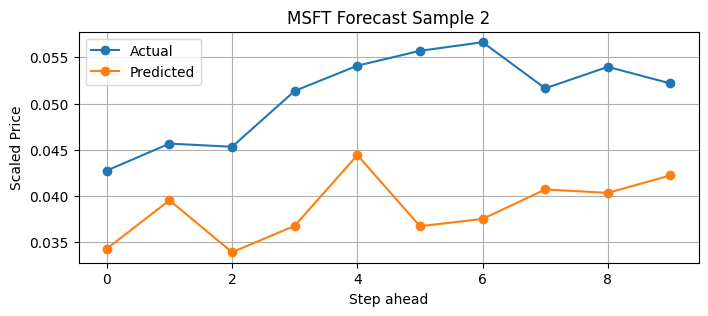

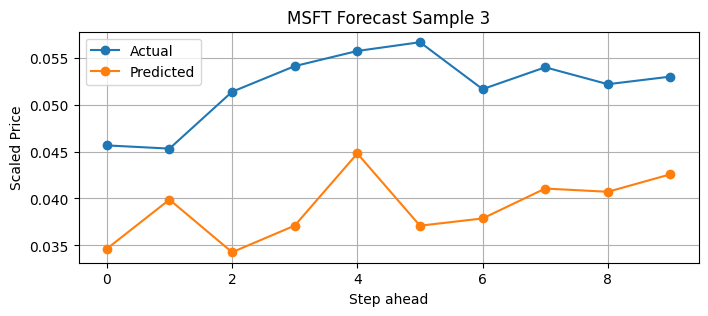

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 350ms/step


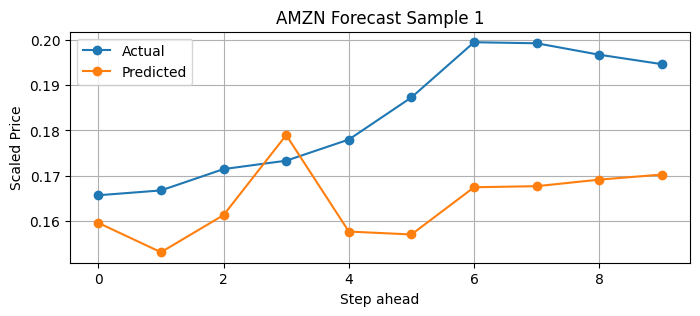

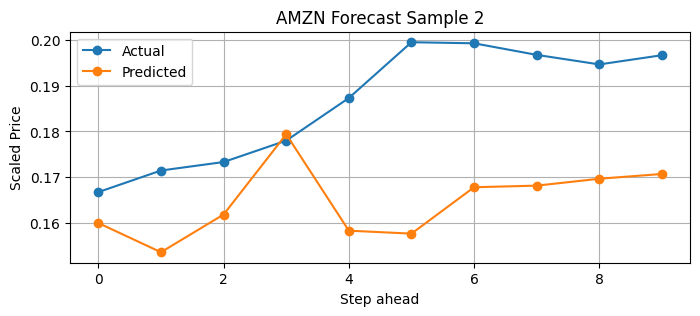

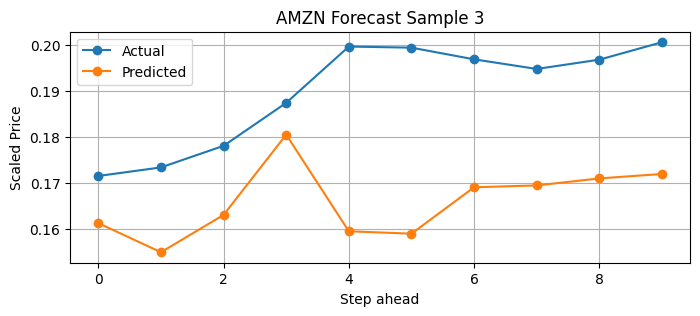

In [ ]:
for ticker in tickers:
    model = models[ticker]
    X_vis = X_all_dict[ticker][:100]
    y_vis = y_all_dict[ticker][:100]
    y_pred = model.predict(X_vis)

    for i in range(3):
        plt.figure(figsize=(8, 3))
        plt.plot(range(steps_ahead), y_vis[i], label="Actual", marker='o')
        plt.plot(range(steps_ahead), y_pred[i], label="Predicted", marker='o')
        plt.title(f"{ticker} Forecast Sample {i+1}")
        plt.xlabel("Step ahead")
        plt.ylabel("Scaled Price")
        plt.legend()
        plt.grid(True)
        plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


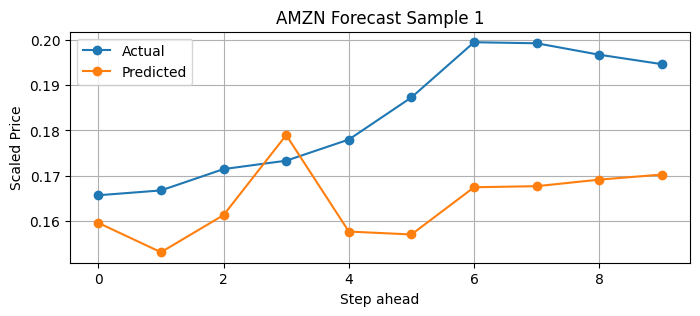

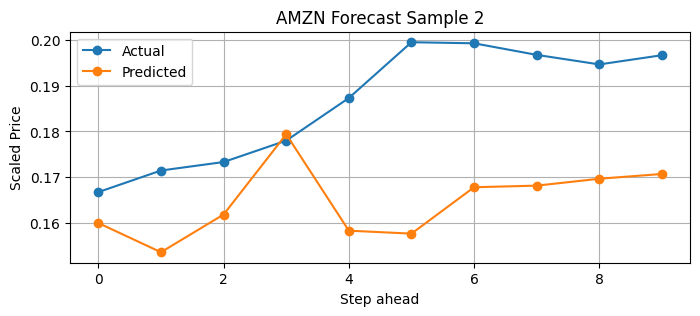

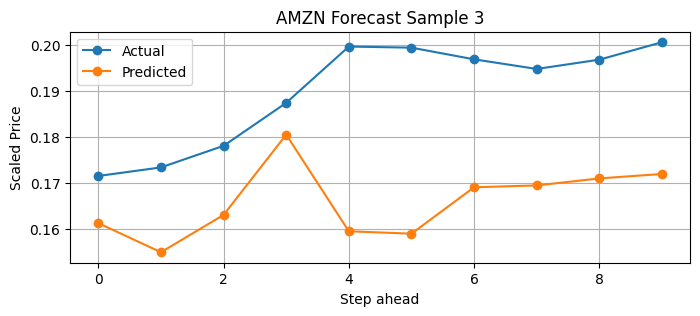

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


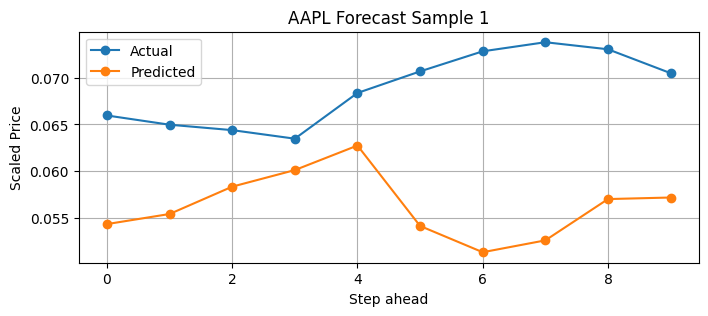

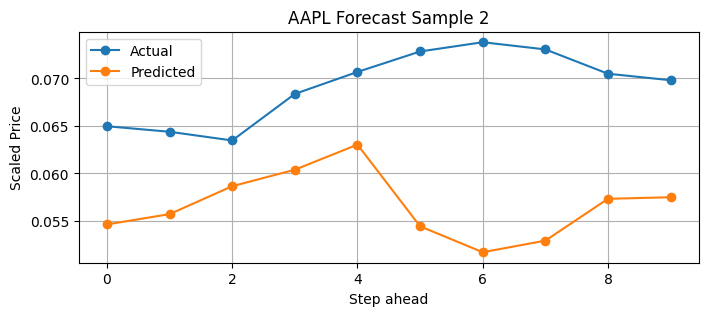

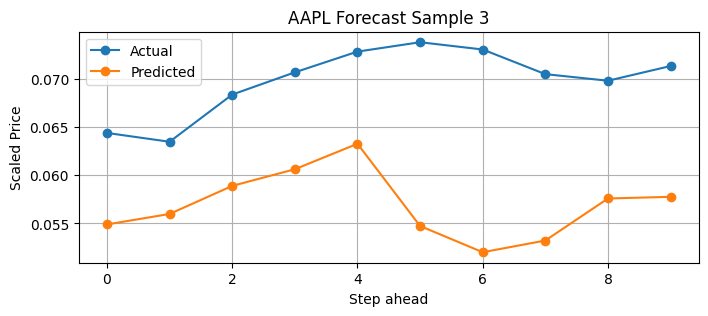

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


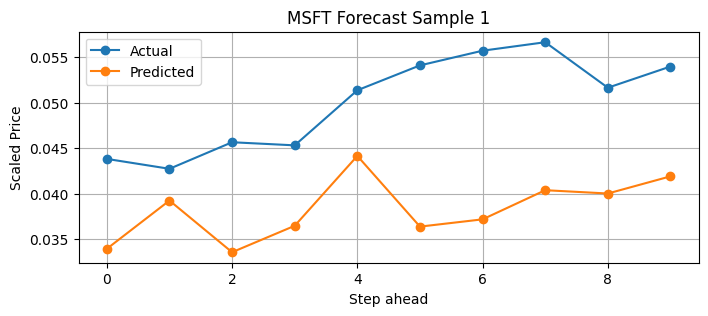

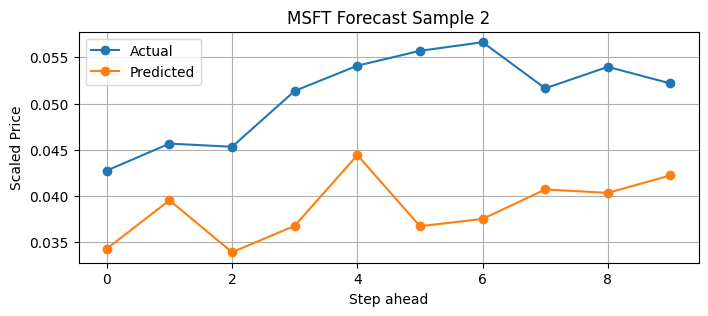

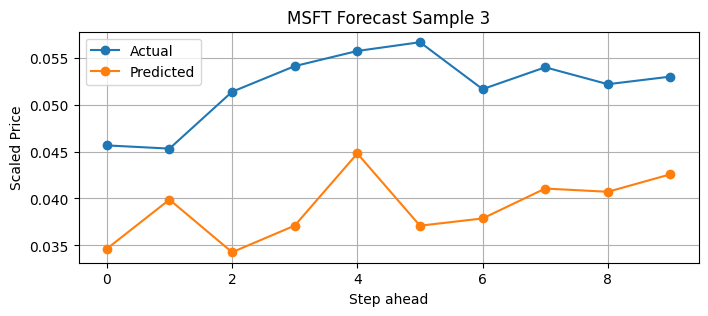

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


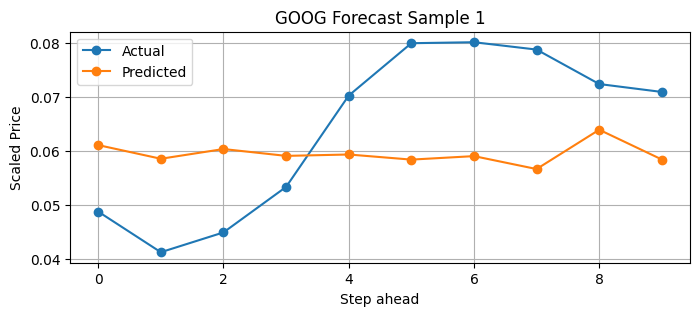

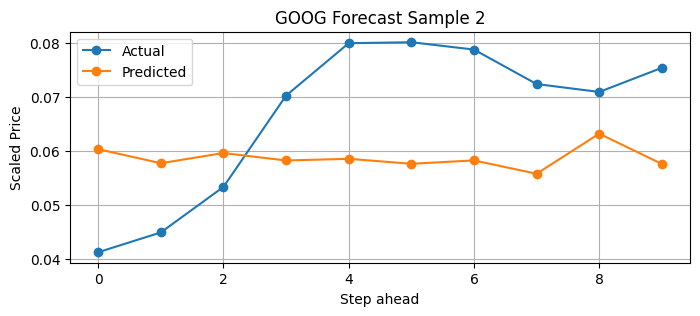

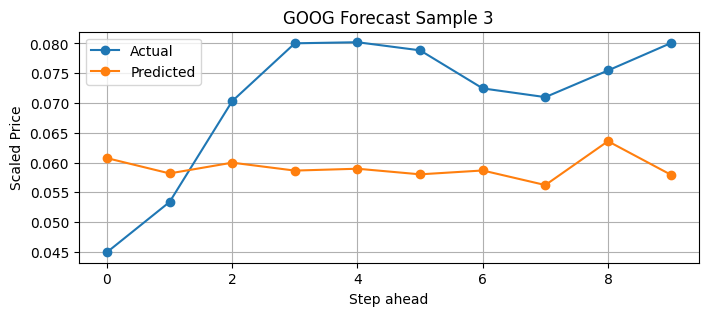

In [ ]:
# Assistant
# First, ensure that all dictionaries contain the same tickers
common_tickers = set(models.keys()) & set(X_all_dict.keys()) & set(y_all_dict.keys())
tickers = list(common_tickers) # Use only tickers that exist in all dictionaries

for ticker in tickers:
    # Check if ticker exists in all dictionaries before proceeding
    if ticker in models and ticker in X_all_dict and ticker in y_all_dict:
        model = models[ticker]
        X_vis = X_all_dict[ticker][:100]
        y_vis = y_all_dict[ticker][:100]
        y_pred = model.predict(X_vis)

        for i in range(3):
            plt.figure(figsize=(8, 3))
            plt.plot(range(steps_ahead), y_vis[i], label="Actual", marker='o')
            plt.plot(range(steps_ahead), y_pred[i], label="Predicted", marker='o')
            plt.title(f"{ticker} Forecast Sample {i+1}")
            plt.xlabel("Step ahead")
            plt.ylabel("Scaled Price")
            plt.legend()
            plt.grid(True)
            plt.show()
    else:
        print(f"Skipping {ticker} as it's not available in all dictionaries")

In [ ]:
predicted_returns = {}
total_money = 10000

for ticker in tickers:
    model = models[ticker]
    X_all = X_all_dict[ticker]
    scaler = scalers[ticker]

    recent_window = X_all[-1]
    pred_scaled = model.predict(np.expand_dims(recent_window, axis=0))[0]
    pred = scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()

    current_price = scaler.inverse_transform(np.array([[recent_window[-1][0]]]))[0][0]
    expected_return = (np.mean(pred) - current_price) / current_price
    predicted_returns[ticker] = expected_return

print("Portfolio Recommendation:")
for ticker, ret in predicted_returns.items():
    action = "Buy" if ret > 0 else "Sell"
    print(f"{action} ${total_money/len(tickers):.2f} of {ticker} (Expected Return: {ret*100:.2f}%)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Portfolio Recommendation:
Buy $2500.00 of AMZN (Expected Return: 0.12%)
Sell $2500.00 of AAPL (Expected Return: -14.99%)
Sell $2500.00 of MSFT (Expected Return: -13.57%)
Sell $2500.00 of GOOG (Expected Return: -0.52%)


In [ ]:
def directional_accuracy(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.sign(np.diff(y_true)) == np.sign(np.diff(y_pred)))

for ticker in tickers:
    model = models[ticker]
    X_vis = X_all_dict[ticker][:100]
    y_vis = y_all_dict[ticker][:100]
    y_pred = model.predict(X_vis)

    mae_list, rmse_list, mape_list, da_list = [], [], [], []

    for i in range(len(y_vis)):
        y_t = y_vis[i]
        y_p = y_pred[i]

        mae_list.append(mean_absolute_error(y_t, y_p))
        rmse_list.append(np.sqrt(mean_squared_error(y_t, y_p)))
        mape_list.append(np.mean(np.abs((y_t - y_p) / (y_t + 1e-5))))
        da_list.append(directional_accuracy(y_t, y_p))

    print(f"\n\Evaluation for {ticker}:")
    print(f"MAE:  {np.mean(mae_list):.4f}")
    print(f"RMSE: {np.mean(rmse_list):.4f}")
    print(f"MAPE: {np.mean(mape_list)*100:.2f}%")
    print(f"Directional Accuracy: {np.mean(da_list)*100:.2f}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

\Evaluation for AMZN:

<>:22: SyntaxWarning: invalid escape sequence '\E'
<>:22: SyntaxWarning: invalid escape sequence '\E'
/tmp/ipython-input-916571604.py:22: SyntaxWarning: invalid escape sequence '\E'
  print(f"\n\Evaluation for {ticker}:")



MAE:  0.0297
RMSE: 0.0328
MAPE: 12.14%
Directional Accuracy: 51.78%
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

\Evaluation for AAPL:
MAE:  0.0143
RMSE: 0.0152
MAPE: 14.22%
Directional Accuracy: 53.67%
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

\Evaluation for MSFT:
MAE:  0.0130
RMSE: 0.0139
MAPE: 18.06%
Directional Accuracy: 51.11%
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

\Evaluation for GOOG:
MAE:  0.0232
RMSE: 0.0251
MAPE: 27.50%
Directional Accuracy: 49.00%


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


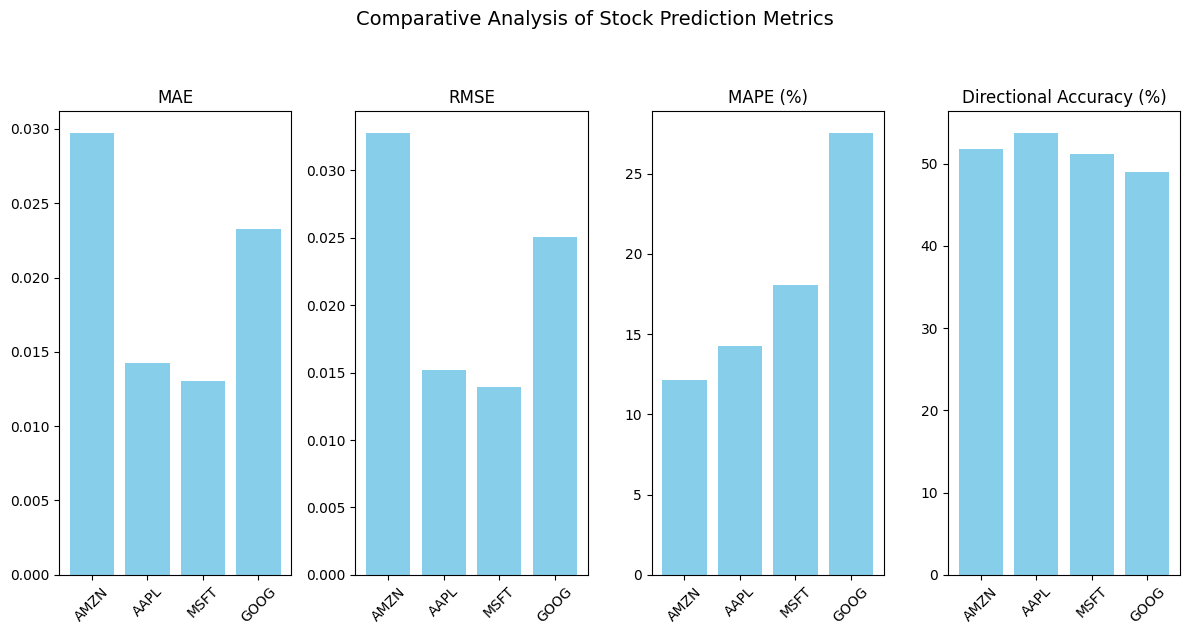

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Function to compute directional accuracy
def directional_accuracy(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.sign(np.diff(y_true)) == np.sign(np.diff(y_pred)))

# Lists to store metric results
tickers_evaluated = []
mae_scores, rmse_scores, mape_scores, da_scores = [], [], [], []

for ticker in tickers:
    model = models[ticker]
    X_vis = X_all_dict[ticker][:100]
    y_vis = y_all_dict[ticker][:100]
    y_pred = model.predict(X_vis)

    mae_list, rmse_list, mape_list, da_list = [], [], [], []

    for i in range(len(y_vis)):
        y_t = y_vis[i]
        y_p = y_pred[i]

        mae_list.append(mean_absolute_error(y_t, y_p))
        rmse_list.append(np.sqrt(mean_squared_error(y_t, y_p)))
        mape_list.append(np.mean(np.abs((y_t - y_p) / (y_t + 1e-5))))
        da_list.append(directional_accuracy(y_t, y_p))

    tickers_evaluated.append(ticker)
    mae_scores.append(np.mean(mae_list))
    rmse_scores.append(np.mean(rmse_list))
    mape_scores.append(np.mean(mape_list) * 100)  # percentage
    da_scores.append(np.mean(da_list) * 100)      # percentage

# Plotting
metrics = ['MAE', 'RMSE', 'MAPE (%)', 'Directional Accuracy (%)']
data = [mae_scores, rmse_scores, mape_scores, da_scores]

plt.figure(figsize=(12, 6))
for i, metric in enumerate(metrics):
    plt.subplot(1, 4, i+1)
    plt.bar(tickers_evaluated, data[i], color='skyblue')
    plt.title(metric)
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.suptitle("Comparative Analysis of Stock Prediction Metrics", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.layers import GRU

def build_gru_model():
    inputs = Input(shape=(window_size, X.shape[2]))
    x = GRU(64, return_sequences=True)(inputs)
    x = GRU(32)(x)
    output = Dense(steps_ahead)(x)
    model = Model(inputs, output)
    model.compile(optimizer='adam', loss='mse')
    return model


In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(y=y_vis, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(y=y_pred, mode='lines', name='Predicted'))
fig.update_layout(title="Actual vs Predicted Prices")
fig.show()


In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=y_pred, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=X_vis, mode='lines', name='Predicted'))
fig.update_layout(title="Actual vs Predicted Prices")
fig.show()
